In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.insert(1, '/home/federico/Università/Tesi_magistrale/my_programs/')

from contact_matrix_utils import *
#from src.interchromosomal_cosegregation import *
from numpy.random import Generator, MT19937
from scipy.stats import pearsonr, spearmanr
from scipy.spatial.distance import squareform
from src.utilities import *

import seaborn as sns

In [2]:
def chromosome_bin_lenght(segregation_table, chrom):
    return np.ceil(segregation_table[chrom]['stop_position'][-1]/resolution).astype(int)

def select_chromosomes_coordinates(chrA, chrB, chr_windows_sizes):
    if(chrA==0 or chrB ==0):
        print("0 is not accepted as chromosome index ")
        return

    chrA_idx, chrB_idx = chrA - 1, chrB - 1

    if(chrA_idx>chrB_idx):
        chrA_idx, chrB_idx = chrB_idx, chrA_idx

    start_row    = np.sum(chr_windows_sizes[:chrA_idx])
    stop_row     = start_row + chr_windows_sizes[chrA_idx]
    start_column = np.sum(chr_windows_sizes[:chrB_idx])
    stop_column  = start_column + chr_windows_sizes[chrB_idx]

    return start_row, stop_row, start_column, stop_column
which_beta = "$\\beta$ evaluated | 1/2"

In [3]:
seg_table = np.loadtxt("/home/federico/Università/Tesi_magistrale/Fiorillo_musella_nature_meth2021/In-silico_Hi-C_GAM_SPRITE/main/gam_segregation_table_457_050.txt")

In [4]:
seg_table.shape

(150, 457)

In [5]:
coseg = compute_tube_cosegregation_matrix(seg_table)

(<Figure size 504x504 with 2 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x7fb8046d5820>)

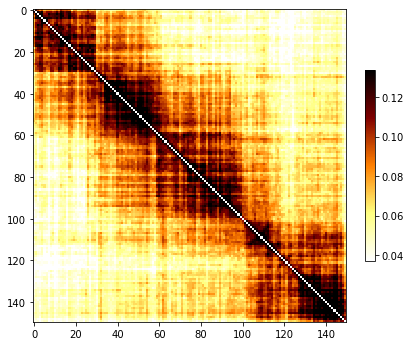

In [6]:
plot_heatmap(coseg)

In [7]:
def scialdone_equation_for_s_mat(R_mat, K, F):
    """ Equation for computing Scialdone's s_mat using a generic R ( M2/(M1+M2) ) term. """
    
    numerator = 1 - 2 * (1 - F) ** (1 / K) + ((1 - 2 * F + R_mat) / (1 + R_mat)) ** (1 / K)
    denominator = (1 - (1 - F) ** (1 / K)) ** 2
    s_mat = numerator / denominator
    
    return s_mat


def compute_s_mat(F_arr, F_mat, K, F):
    """ Computes the SLICE-normalized Co-Segregation matrix. """

    F_i = np.tile(F_arr, (len(F_arr), 1))
    F_j = np.transpose(F_i)
    F_ij = F_mat
    R_ij = F_ij / (F_i + F_j - F_ij)
    s_mat = scialdone_equation_for_s_mat(R_ij, K, F)
    np.fill_diagonal(s_mat, np.nan)

    return s_mat


def compute_beta_mat(F_arr, F_mat, K, F, alpha):
    """ Computes beta matrix using Scialdone's method. """

    F_ij = F_mat
    F_i = np.tile(F_arr, (len(F_arr), 1))
    F_j = np.transpose(F_i)
    F_i_plus_F_j = F_i + F_j

    # Conditions of low statistic to stop the evaluation of beta at high genomic distances
    # If at a given genomic distance (i.e. diagonal) there are less than stop_threshold non-NaN values,
    # the algorithm stops performing the average for the current and next diagonals.
    # Instead, the value of beta for the last non-NaN diagonal is used.
    # Since the number of NaNs of F_ij and F_i + F_j is the same
    # (F_mat[:, np.isnan(F_arr)] = np.nan and F_mat[np.isnan(F_arr), :] = np.nan in the main)
    # we can evaluate the number of NaNs in both matrices.
    stop_threshold = 20  # 100
    stop_average = False
    last_beta = np.nan

    beta_mat = np.nan * np.ones(F_mat.shape)  # initialize with all nans

    # First, we perform a loop filling beta_mat on the upper-diagonals
    for diagonal_index in np.arange(1, len(beta_mat)):

        # First, if stop_average is True, beta doesn't have to be computed. Instead, the last non-NaN beta is used
        if stop_average:
            beta_mat[kth_diag_indices(beta_mat, diagonal_index)] = last_beta
            continue

        # If the diagonal has less than stop_threshold non-NaN values, beta doesn't have to be computed for this
        # diagonal and the next ones, so stop_average is set as True
        if np.sum(~np.isnan(np.diagonal(F_ij, diagonal_index))) < stop_threshold:
            stop_average = True
            beta_mat[kth_diag_indices(beta_mat, diagonal_index)] = last_beta
            continue

        F_ij_diagonal_mean = np.nanmean(np.diagonal(F_ij, diagonal_index))
        F_i_plus_F_j_diagonal_mean = np.nanmean(np.diagonal(F_i_plus_F_j, diagonal_index))
        R_ij_diagonal_mean = F_ij_diagonal_mean / (F_i_plus_F_j_diagonal_mean - F_ij_diagonal_mean)
        beta = scialdone_equation_for_s_mat(R_ij_diagonal_mean, K, F)
        last_beta = beta  # The last non-NaN beta value is updated
        beta_mat[kth_diag_indices(beta_mat, diagonal_index)] = beta

    # Now we fill the lower-diagonals symmetrically using the squareform function
    beta_mat = squareform(beta_mat, checks=False)
    beta_mat = squareform(beta_mat)

    # We set as 0 the entries where beta is negative, and as alpha the entries where beta > alpha
    beta_mat[beta_mat < 0] = 0
    beta_mat[beta_mat > alpha] = alpha

    return beta_mat


def compute_pi(s_mat, beta_mat, alpha):
    """ Computes the PI matrix. """

    pi_mat = (s_mat - beta_mat) / (alpha - beta_mat)
    np.fill_diagonal(pi_mat, np.nan)

    return pi_mat

def compute_alpha(r_cell, resolution, genome_length, h):

    r_win = r_cell * (resolution / genome_length)**(1/3)
    alpha = (h + 2 * r_win + 2 * r_cell) / (h + 2 * r_win)

    return alpha

A = compute_alpha(4.6 ,  30 * 10**3 , 5.20 * 10**9 , 0.22)

In [8]:
n_tubes = np.shape(seg_table)[1]

K = 2

F_arr = compute_tube_segregation_frequency(seg_table)
F_mat = compute_tube_cosegregation_matrix(seg_table)

F = np.nanmean(F_mat)

F_mat[:, np.isnan(F_arr)] = np.nan
F_mat[np.isnan(F_arr), :] = np.nan

s_mat = compute_s_mat(F_arr, F_mat, K, F)

beta_mat = compute_beta_mat(F_arr, F_mat, K, F, A)
beta_arr = beta_mat[0, :]

pi_mat = compute_pi(s_mat, beta_mat, A)
pi_mat[np.isinf(pi_mat)] = np.nan

pi_mat[pi_mat < 0] = np.nan
pi_mat[pi_mat > 1] = 1.

(<Figure size 504x504 with 2 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x7fb8047561f0>)

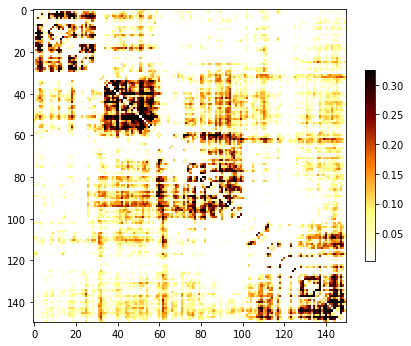

In [9]:
plot_heatmap(pi_mat)

(<Figure size 504x504 with 2 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x7fb80054f520>)

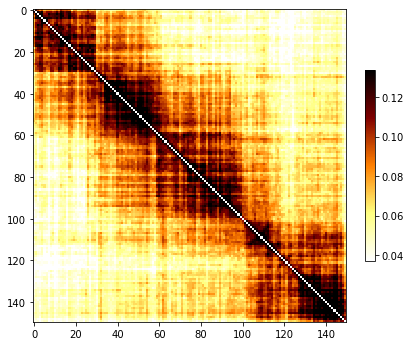

In [10]:
plot_heatmap(coseg)